In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Dynamic Models for Building Energy Management 

DENIS Yann / DIAZ Hugo / QUENEZ Erwan / JOUAULT-COUTEAU Kilian                                       
2A SEM 
30/05/2023 

## Parameters
### Dimension of the Building 

Each Room has a cubic shape
![building](Schema.png)
> Figure 1. Schema of the building

In [2]:
l = 3              # m length of the cubic room
Sg = l**2          # m² surface of the glass wall
Sc = Si = 10 * Sg  # m² surface of concrete & insulation of the walls

We consider that M1,M2,M3 are inside the building and M4 is outside. Then the only exchange are between the inside and the outside with M4 and between the two rooms with M5

### Thermo-Physical Properties
We consider than the wall is made of a width of insulation and a width of concrete (eM=eI+eC)

In [3]:
concrete = {'Conductivity': 1.400,
            'Density': 2400.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 9 * l**2}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.1,
              'Surface': 9 * l**2}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': 2*(l**2)}

wall = pd.DataFrame.from_dict({'Layer_out': insulation,
                               'Layer_in': concrete,
                               'Glass': glass},
                              orient='index')
wall

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


### Radiative properties

The radiative properties of the surfaces are:

- long wave emmisivity of concrete (between normal and rough) and glass pyrex;
- short wave absortivity of solar radiation of white smooth surfaces;
- short wave transmittance of window glass (thickness of 4 mm);
- short wave absortivity and transmittance of reflective blue window glass.

In [4]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### Convection properties

In [5]:
h0 = pd.DataFrame([{'in': 8., 'out': 25}], index=['h0'])  # W/(m²⋅K)
# h = pd.DataFrame([{'in': 8., 'out': 25}])  # W/(m²⋅K)
h0

,in,out
h0,8.0,25


To take into account the long wave radiation, we add 4 at the value of h_in

In [6]:
h = pd.DataFrame([{'in': 12., 'out': 25}], index=['h'])  # W/(m²⋅K)
# h = pd.DataFrame([{'in': 8., 'out': 25}])  # W/(m²⋅K)
h

,in,out
h,12.0,25


### Thermal circuit

Figure bellow shows the models of :

concrete & insulation wall: in red;
glass window: in green;
ventilation: in magenta;
indoor volume: in blue (conductances 6 & 7 for convection; conductance 5 for long wave radiation between the walls and the glass window);
HVAC system: in black.

Here is the thermal circuit :
![thermal circuit](Schemathermique.png)
> Figure 2. Schema of the thermal circuit

The sources are:

- T0 outdoor temperature, °C;
- Ti,sp setpoint temperaure for the indoor air, °C;
- ϕ0 solar radiation absorbed by the outdoor surface of the wall, W;
- ϕi solar radiation absorbed by the indoor surface of the wall, W;
- Qa auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- ϕa solar radiation absorbed by the glass, W.

### Conductance

The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by conduction. Conduction conductances, in W/K, are of the form: 

$$G_{cd}=\frac{\lambda }{w}*S$$

where:

 - $\lambda$ : thermal conductvity, W/(m⋅K);
 - w : width of the material, m;
 - S : surface area of the wall, m²

In [7]:

# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Layer_out,21.87
Layer_in,567.00
Glass,630.00


#### Convection
The conductances of the walls and the glasses are convection conductances. Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the convection coefficient, W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [8]:
# Convection wall
Gw = h * wall['Surface'][0]     # wall
print(f'Gw = {Gw} W/K')

Gw =       in   out
h  972.0  2025 W/K


In [9]:
# Convection glass
Gg = h * wall['Surface'][2]     # glass
print(f'Gg = {Gg} W/K')

Gg =       in  out
h  216.0  450 W/K


In [10]:
# Long wave radiation

# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']
print(f'Fwg = {Fwg}')

Fwg = 0.2222222222222222


As explained before we do not need these factors because it is included in the value of h_in

#### Advection

The volumetric flow rate of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  (air changes per hour) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [11]:
# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
print(f'Va_dot = {Va_dot} m³/s')

Va_dot = 0.0075 m³/s


The conductance of advection by ventilation and/or infiltration, in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

In [12]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot
print(f'Gv = {Gv} W/K')

Gv = 9.0 W/K


#### Proportional controller

In the simplest representation, the HVAC systemcan be considered as a proportional controller that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the HVAC system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature setpoint, °C ;
- $\theta_i$ - indoor temperature, °C.

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends towards:
- infinity, $K_p \rightarrow \infty$, then the controller is perfect, $\theta_i \rightarrow T_{i, sp}$.
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ .


In [13]:
# Proportionnal Controller
# P-controler gain
Kp = 1e6            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

## Thermal Capacities
#### Walls
The thermal capacities of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - specific heat capacity, J/(kg⋅K);
- $\rho_w$ - density, kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - density of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [14]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Layer_out,539055.0
Layer_in,34214400.0
Glass,2178000.0
Air,32400.0


## System of algebraic_differential equations (DAE)
### A : Incident Matrix

The incidence matrix is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

In [15]:
A = np.zeros([18, 11])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 5], A[6, 6] = -1, 1    # branch 6: node 5 -> node 6
A[7, 6], A[7, 7] = -1, 1    # branch 7: node 6 -> node 7
A[8, 7], A[8, 8]= 1, -1     # branch 8: node 7 -> node 8
A[9, 8]= 1                 # branch 9: -> node 8
A[10, 7], A[10, 9]= -1, 1   # branch 10: node 7 -> node 9
A[11, 9], A[11, 6]= 1, -1   # branch 11: node 9 -> node 6
A[12, 10], A[12, 2]= -1, 1  # branch 12: node 10-> node 2
A[13, 1], A[13, 10]= -1, 1  # branch 13: node 1 -> node 10
A[14, 10] = 1               # branch 14: -> node 10
A[15, 10] = 1               # branch 15: -> node 10
A[16, 9] = 1                # branch 16: -> node 9
A[17, 9] = 1                # branch 17: -> node 9

# np.set_printoptions(suppress=False)
# pd.DataFrame(A)

### G : Incident Matrix

The conductance matrix of the themal circuit is diagonal where : 

In [16]:
G = np.zeros([18, 18])       # n° of branches X n° of nodes
G[0, 0] = (h['out']*glass['Surface'])/2                
G[1, 1] = (glass['Conductivity']*glass['Surface']/2)/glass['Width']
G[2, 2] = 0
G[3, 3] = (concrete['Conductivity']*concrete['Surface']/2)/concrete['Width']
G[4, 4] = (concrete['Conductivity']*concrete['Surface']/2)/concrete['Width']              
G[5, 5] = (insulation['Conductivity']*insulation['Surface']/2)/insulation['Width']
G[6, 6] = (insulation['Conductivity']*insulation['Surface']/2)/insulation['Width']
G[7, 7] = 0
G[8, 8] = (glass['Conductivity']*glass['Surface']/2)/glass['Width']                  
G[9, 9] = (h['out']*glass['Surface'])/2 
G[10, 10] = (h['in']*glass['Surface'])/2  
G[11, 11] = (h['in']*concrete['Surface'])/2 
G[12, 12] = (h['in']*concrete['Surface'])/2                   
G[13, 13] = (h['in']*glass['Surface'])/2 
G[14, 14] = Gv 
G[15, 15] = Kp
G[16, 16] = Kp                  
G[17, 17] = Gv
print(f'G = ', G)

G =  [[2.2500e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.1500e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 2.8350e+02 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.8350e+02 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.00

### C : Capacity Matrix

The capacity matrix of the themal circuit  is diagonal:

$ C = \begin{cases}
C_{0,0} = C_{Glass} & \text{glass of the windows}\\ 
C_{3,3} = C_{Layer\,out} & \text{outer layer of the wall}\\
C_{5,5} = C_{Layer\,in} & \text{inner layer of the wall}\\ 
C_{8,8} = C_{Glass} & \text{glass of the windows}\\
C_{9,9} = C_{Air} & \text{air of the room}\\
C_{10,10} = C_{Air} & \text{air of the room}\\
\end{cases}$

The thermal capacities of the air and of the glass can be neglected or not.

In [17]:
neglect_air_glass = True

if neglect_air_glass:
    C = np.diag([0, 0, 0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                 0, 0, 0])
else:
    C = np.diag([C['Glass'], 0, 0, C['Layer_out'], 0, C['Layer_in'], 0, 0, C['Glass'],
                 C['Air'], C['Air']])

print(f'C = ', C)
# pd.set_option("display.precision", 3)
# pd.DataFrame(C)

C =  [[       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.   539055.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0. 34214400.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
   

### b : temperature source vector 

For the thermal,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &0  &0  &0  &T_o  &T_{i,sp}  &T_{i,sp}  &T_o 
\end{matrix}]^T$$

where:
- $T_o$ is the outdoor temperature, °C;
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C.

Since the temperature sorces $T_o$ and $T_{i,sp}$ are time series, in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [18]:
b = np.zeros(18)        # branches
b[[0, 9, 14, 15, 16, 17]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.]


### f : heat flow source  vector 

For the thermal circuit,

$$f = [\begin{matrix}
\Phi_a &0 &\Phi_i &0  &0  &0  &\Phi_i  &0  &\Phi_a  &\dot{Q_a} &\dot{Q_a} 
\end{matrix}]^T$$

where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

Since the flow rate sorces $\Phi_o$, $\Phi_i$, $\dot{Q}_a$ and $\Phi_a$ are time series, in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [19]:
f = np.zeros(11)         # nodes
f[[0, 2, 6, 8, 9, 10]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.]


### y : output vector 

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes. The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0  &0  &0  &0  &\theta_9 &\theta_{10} 
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [20]:
y = np.zeros(11)         # nodes
y[[9, 10]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


## State-space representation

The differential-algebraic system of equations (DAE)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in state-space representation:

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$


In [21]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-3.51632886e-04  1.95321179e-05]
 [ 3.07732587e-07 -6.20298705e-07]] 

Bs = 
 [[1.96748470e-08 0.00000000e+00 2.98870294e-09 3.32078105e-04
  0.00000000e+00 0.00000000e+00 8.74437643e-11 6.83666992e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.32078105e-10]
 [0.00000000e+00 1.85175438e-11 0.00000000e+00 0.00000000e+00
  3.12544787e-07 2.81290308e-12 0.00000000e+00 0.00000000e+00
  6.43452704e-10 8.23001947e-14 3.12544787e-13 0.00000000e+00]] 

Cs = 
 [[0.00000000e+00 1.06935324e-05]
 [1.79008363e-04 0.00000000e+00]] 

Ds = 
 [[0.00000000e+00 5.92429721e-05 0.00000000e+00 0.00000000e+00
  9.99921064e-01 8.99928958e-06 0.00000000e+00 0.00000000e+00
  9.77917911e-07 2.63302098e-07 9.99921064e-07 0.00000000e+00]
 [5.92330006e-05 0.00000000e+00 8.99777485e-06 9.99752761e-01
  0.00000000e+00 0.00000000e+00 2.63257780e-07 6.31422796e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99752761e-07]] 



### Steady State

First we are going to check the model in steady state to see if it is correct.
We are going to consider that : 

- The controller is not active, $K_p \rightarrow 0$,
- The outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- The indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- All flow rate sources are zero.

In [22]:
b = np.zeros(18)        # temperature sources
b[[0, 9, 14, 17]] = 10      # outdoor temperature
b[[15, 16]] = 20            # indoor set-point temperature
print(f'b = ', b)

f = np.zeros(11)         # flow-rate sources
print(f'f = ', f)

b =  [10.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0. 10. 20. 20. 10.]
f =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### System of Differential Algebraic Equations (DAE)
The value of temperature in steady-state is obtained from the system of DAE by considering that $C \dot{\theta} = 0$ , then we have : $$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

In [23]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [12.63304914 14.51379853 19.99931757 19.99931757 19.99931757 19.99931757
 19.99931757 14.51379853 12.63304914 19.99931757 19.99931757] °C


In [24]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-3.51632886e-04  1.95321179e-05]
 [ 3.07732587e-07 -6.20298705e-07]] 

Bs = 
 [[1.96748470e-08 0.00000000e+00 2.98870294e-09 3.32078105e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85175438e-11 0.00000000e+00 0.00000000e+00
  3.12544787e-07 2.81290308e-12]] 

Cs = 
 [[0.00000000e+00 1.06935324e-05]
 [1.79008363e-04 0.00000000e+00]] 

Ds = 
 [[0.00000000e+00 5.92429721e-05 0.00000000e+00 0.00000000e+00
  9.99921064e-01 8.99928958e-06]
 [5.92330006e-05 0.00000000e+00 8.99777485e-06 9.99752761e-01
  0.00000000e+00 0.00000000e+00]] 



### State-space representation
The input vector u is described bellow : 
$$
u = \begin{bmatrix}
b_T \\
f_Q
\end{bmatrix}
$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. 
    - $b_T = [T_o, T_o, T_o, T_{i,sp}, T_{i,sp},T_o]^T$ corresponding to branches 0, 9, 14, 15, 16 and 17, 

- $f_Q$ vector: the nonzero elements of vector $f$ of flow sources. $f_Q = [\Phi_a, \Phi_i, \Phi_i, \Phi_a, \dot{Q}_a, \dot{Q}_a]^T$ corresponding to nodes 0, 2, 6, 8, 9, 10 where:
    - $\Phi_o$: solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_i$: solar radiation absorbed by the indoor surface of the wall, W;
    - $\dot{Q}_a$: auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
    - $\Phi_a$: solar radiation absorbed by the glass, W.

In [25]:
bT = np.array([[10], [10], [10], [20], [20], [10]])     # [To, To, To, Tisp, Tisp, To]
fQ = np.array([[0], [0], [0], [0], [0], [0]])         # [Φa, Φi, Φi, Φa, Qa, Qa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [[10  0]
 [10  0]
 [10  0]
 [20  0]
 [20  0]
 [10  0]]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [26]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [[19.99931757  0.        ]
 [19.99931757  0.        ]] °C


The error between the steady-state values obtained from the system of DAE, $\theta_9$ and $\theta_{10}$ , and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon_1 = \left | \theta_9 - y_{ss} \right |$$
$$\varepsilon_2 = \left | \theta_{10} - y_{ss} \right |$$

is practically zero; the slight difference is due to numerical errors.

In [27]:
eps1=(abs(θ[9] - yss[0,0]))
print(f'eps1 = \
{eps1:.2e} °C')
eps2=(abs(θ[10] - yss[1,0]))
print(f'eps2 = \
{eps2:.2e} °C')
print(f'Max error between DAE and state-space: \
{max(eps1,eps2):.2e} °C')

eps1 = 3.55e-15 °C
eps2 = 3.55e-15 °C
Max error between DAE and state-space: 3.55e-15 °C


## Dynamic Simulation

### Time Step
To set up the time step we are going to determine the maximum time step.
The condition for numerical stability of Euler explicit integration method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition becomes

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the time constants, $T_i = - \frac{1}{\lambda_i} $

In [28]:
λ = np.linalg.eigvals(As)    # eigenvalues of matrix As

print('Time constants : \n', -1 / λ, 's \n')
print('2 x Time constants : \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.6f} s = {dtmax / 60:.6f} min')

Time constants : 
 [   2843.73659554 1657891.61112565] s 

2 x Time constants : 
 [   5687.47319108 3315783.22225129] s 

Maximum time step: 5687.473191 s = 94.791220 min


We will chose a time step smaller than : $\Delta t_{\text{max}} = \min \left(-\frac{2}{\lambda_i}\right)$

In [29]:
# time step

dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 5640.0 s = 94 min


We can neglect the air and glass capacity to have a relatively long time step.

### Settling time
We consider that the settling time is roughly 4 times the larger time constant.

In [30]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  11372 6631564] s 

Settling time: 6631566 s = 110526.1 min = 1842.10 h = 76.75 days


### Step response
We are now going to determine the dynamic response of the system to a step input.

#### Duration
We pay attention to make the duration of the simulation larger than the estimated settling time. Then it will give a number of time steps in the time vector

In [31]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600/5
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 1326960.0 s
Number of time steps = 235


#### Input vector
The input vector as the same shape as in the last part : 
$$
u = \begin{bmatrix}
b_T \\
f_Q
\end{bmatrix}
$$


In [32]:
u = np.zeros([12, n])                # u = [To To To Tisp Tisp To Φa, Φi, Φi, Φa, Qa, Qa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps pr (0, 1, 2)
u[3:5, :] = 20 * np.ones([2, n])      # Tisp = 20 for n time steps pr (3, 4)
u[5, :] = 10 * np.ones([1, n])      # To = 10 for n time steps pr (5)

# pd.DataFrame(u)

In dynamic simulation, the inputs are time series, e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &0  &0  &0  &T_o  &T_{i,sp}  &T_{i,sp}  &T_o 
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_{i,sp} T_{i,sp} T_o]^T$$
corresponding to branches 0, 9, 14, 15, 16 and 17; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3,

$$f = [\begin{matrix}
\Phi_a &0 &\Phi_i &0  &0  &0  &\Phi_i  &0  &\Phi_a  &\dot{Q_a} &\dot{Q_a} 
\end{matrix}]^T$$

and

$$f_Q = [\Phi_a, \Phi_i, \Phi_i, \Phi_a, \dot{Q}_a, \dot{Q}_a]^T$$

corresponding to nodes 0, 2, 6, 8, 9 and 10.

For the thermal circuit shown in Figure 3, the time series() of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\
T_o\\
T_o\\
T_{i,sp}\\
T_{i,sp}\\
T_0\\
\Phi_a\\
\Phi_i\\
\Phi_i\\
\Phi_a\\
\dot{Q}_a\\
\dot{Q}_a\\
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{i,sp(0)} & T_{i,sp(1)}& \dots & T_{i,sp(n-1)}\\
T_{i,sp(0)} & T_{i,sp(1)}& \dots & T_{i,sp(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
\Phi_{a,(0)} & \Phi_{a,(1)} & \dots & \Phi_{a,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & \dots & \Phi_{i,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & \dots & \Phi_{i,(n-1)}\\
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & \dots & \dot{Q}_{a(n-1)}\\
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & \dots & \dot{Q}_{a(n-1)}\\
\end{bmatrix}$$


where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the time series of the oudoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the time series of the setpoint indoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]^T$ is the time series of the solar radiation absorbed by the outdoor surface of the wall at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]^T$ is the time series of the solar radiation absorbed by the indoor surface of the wall at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]^T$ is the time series of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]^T$ is the time seriesof the solar radiation absorbed by the glass at discrete time $t = [t_0, t_1, ... , t_{n-1}]^T$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero (including the HVAC system).

#### Time Integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using Euler forward (or explicit) method for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and Euler backward (or implicit) method for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [33]:
b = np.zeros(18)        # temperature sources
b[[0, 9, 14, 17]] = 10      # outdoor temperature
b[[15, 16]] = 20            # indoor set-point temperature
print(f'b = ', b)
f = np.zeros(11)         # nodes
f[[0, 2, 6, 8, 9, 10]] = 1     # nodes with heat-flow sources
print(f'f = ', f)
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

b =  [10.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0. 10. 20. 20. 10.]
f =  [1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.]
As = 
 [[-3.51632886e-04  1.95321179e-05]
 [ 3.07732587e-07 -6.20298705e-07]] 

Bs = 
 [[1.96748470e-08 0.00000000e+00 2.98870294e-09 3.32078105e-04
  0.00000000e+00 0.00000000e+00 8.74437643e-11 6.83666992e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.32078105e-10]
 [0.00000000e+00 1.85175438e-11 0.00000000e+00 0.00000000e+00
  3.12544787e-07 2.81290308e-12 0.00000000e+00 0.00000000e+00
  6.43452704e-10 8.23001947e-14 3.12544787e-13 0.00000000e+00]] 

Cs = 
 [[0.00000000e+00 1.06935324e-05]
 [1.79008363e-04 0.00000000e+00]] 

Ds = 
 [[0.00000000e+00 5.92429721e-05 0.00000000e+00 0.00000000e+00
  9.99921064e-01 8.99928958e-06 0.00000000e+00 0.00000000e+00
  9.77917911e-07 2.63302098e-07 9.99921064e-07 0.00000000e+00]
 [5.92330006e-05 0.00000000e+00 8.99777485e-06 9.99752761e-01
  0.00000000e+00 0.00000000e+00 2.63257780e-07 6.31422796e-07
  0.00000000e+00 0.0000

In [34]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [35]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
#print('y_exp = \n', y_exp, '\n')
#print('y_imp = \n', y_imp, '\n')

The results of explicit and implicit Euler integration are practically identical.

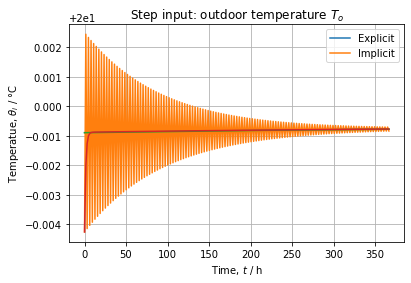

In [36]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

> Figure 3. Step response to outdoor temperature by using Euler implicit and explicit integration.

The value the indoor temperature obtained after the settling time is almost equal to the value obtained in steady-state.

When the proportional gain coefficient (Kp) is very low or zero, regulation is absent and the solution reaches the fixed outdoor temperature of 10°C. This is consistent.

Secondly, the time step used in the simulation plays an essential role. When the time step is reduced, the time samples are closer together, which allows rapid variations in the system to be captured more accurately. As a result, the response shows fewer oscillations because abrupt changes are better represented. On the other hand, with a high time step, the simulation risks missing rapid variations and underestimating the response of the system, leading to an oscillating and unstable response. Consequently, it is important to adjust the time step in the numerical simulations appropriately in order to obtain an accurate and stable response from the system under study.

In [37]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model 1: {float(θ[9]):.4f} °C')
print(f'- DAE model 2: {float(θ[10]):.4f} °C')
print(f'- state-space model in room 1 : {float(yss[0][0]):.4f} °C')
print(f'- state-space model in room 2 : {float(yss[1][0]):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2][0]):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2][1]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model 1: 19.9993 °C
- DAE model 2: 19.9993 °C
- state-space model in room 1 : 19.9993 °C
- state-space model in room 2 : 19.9993 °C
- steady-state response to step input: 19.9992 °C
- steady-state response to step input: 19.9993 °C


## Simulation with weather data
### Start and End time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [38]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [39]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


### Inputs
#### Read weather data
Dynamic simulation needs time series of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on Weather data and solar radiation).

In [40]:
filename = 'FRA_NC_Lille-Lesquin.AP.070150_TMYx.2007-2021.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:

- hourly outdoor air temperature, °C;
- hourly solar direct normal irradiance (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or diffuse sky radiation), W/m²,
from the start to the end date.

In [41]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
#weather = weather.loc[start_date:end_date]

#### Solar irradiance on the walls
For the surface orientation given by slope, azimuthand latitude, and the albedo of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,
for hourly solar irradiance on a tilted surface.

In [42]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
#pd.DataFrame(rad_surf)

The total solar irradiance $E_{tot}$ , in W/m², is the sum of direct, diffuse, and reflected components.

In [43]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

#### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [44]:
#resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

,To,Φtot
2000-01-01 00:00:00+01:00,7.20,0.0
2000-01-01 01:34:00+01:00,7.11,0.0
2000-01-01 03:08:00+01:00,7.02,0.0
2000-01-01 04:42:00+01:00,6.93,0.0
2000-01-01 06:16:00+01:00,6.84,0.0
...,...,...
2000-12-31 16:28:00+01:00,9.80,0.0
2000-12-31 18:02:00+01:00,9.80,0.0
2000-12-31 19:36:00+01:00,9.80,0.0
2000-12-31 21:10:00+01:00,9.80,0.0


#### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [45]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data)

,To,Φtot,Ti,Qa
2000-01-01 00:00:00+01:00,7.20,0.0,20.0,0.0
2000-01-01 01:34:00+01:00,7.11,0.0,20.0,0.0
2000-01-01 03:08:00+01:00,7.02,0.0,20.0,0.0
2000-01-01 04:42:00+01:00,6.93,0.0,20.0,0.0
2000-01-01 06:16:00+01:00,6.84,0.0,20.0,0.0
...,...,...,...,...
2000-12-31 16:28:00+01:00,9.80,0.0,20.0,0.0
2000-12-31 18:02:00+01:00,9.80,0.0,20.0,0.0
2000-12-31 19:36:00+01:00,9.80,0.0,20.0,0.0
2000-12-31 21:10:00+01:00,9.80,0.0,20.0,0.0


#### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left[ T_o, T_o, T_o, T_{i,sp}, T_{i,sp}, T_0 \right]^T$ and vectors of time series of the heat flow sources $\left[ \Phi_a, \Phi_i, \Phi_i, \Phi_a, \dot{Q}_a, \dot{Q}_a \right]^T$ 

$$u = 
\begin{bmatrix}
T_o\\
T_o\\
T_o\\
T_{i,sp}\\
T_{i,sp}\\
T_0\\
\Phi_a\\
\Phi_i\\
\Phi_i\\
\Phi_a\\
\dot{Q}_a\\
\dot{Q}_a\\
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
T_{i,sp(0)} & T_{i,sp(1)}& \dots & T_{i,sp(n-1)}\\
T_{i,sp(0)} & T_{i,sp(1)}& \dots & T_{i,sp(n-1)}\\
T_{o(0)} & T_{o(1)}& \dots & T_{o(n-1)}\\
\Phi_{a,(0)} & \Phi_{a,(1)} & \dots & \Phi_{a,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & \dots & \Phi_{i,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & \dots & \Phi_{i,(n-1)}\\
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & \dots & \dot{Q}_{a(n-1)}\\
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & \dots & \dot{Q}_{a(n-1)}\\
\end{bmatrix}$$

where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [46]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

print('Φo = \n', Φo, '\n')
print('To = \n', To, '\n')
u = pd.concat([To, To, To, Ti, Ti, To, Φa, Φi, Φi, Φa, Qa, Qa], axis=1)
u.columns.values[[6, 7, 8, 9]] = ['Φa', 'Φi','Φi', 'Φa']
pd.DataFrame(u)

Φo = 
 2000-01-01 00:00:00+01:00    0.0
2000-01-01 01:34:00+01:00    0.0
2000-01-01 03:08:00+01:00    0.0
2000-01-01 04:42:00+01:00    0.0
2000-01-01 06:16:00+01:00    0.0
                            ... 
2000-12-31 16:28:00+01:00    0.0
2000-12-31 18:02:00+01:00    0.0
2000-12-31 19:36:00+01:00    0.0
2000-12-31 21:10:00+01:00    0.0
2000-12-31 22:44:00+01:00    0.0
Freq: 5640S, Name: Φtot, Length: 5607, dtype: float64 

To = 
 2000-01-01 00:00:00+01:00    7.20
2000-01-01 01:34:00+01:00    7.11
2000-01-01 03:08:00+01:00    7.02
2000-01-01 04:42:00+01:00    6.93
2000-01-01 06:16:00+01:00    6.84
                             ... 
2000-12-31 16:28:00+01:00    9.80
2000-12-31 18:02:00+01:00    9.80
2000-12-31 19:36:00+01:00    9.80
2000-12-31 21:10:00+01:00    9.80
2000-12-31 22:44:00+01:00    9.80
Freq: 5640S, Name: To, Length: 5607, dtype: float64 



,To,To,To,Ti,Ti,To,Φa,Φi,Φi,Φa,Qa,Qa
2000-01-01 00:00:00+01:00,7.20,7.20,7.20,20.0,20.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:34:00+01:00,7.11,7.11,7.11,20.0,20.0,7.11,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:08:00+01:00,7.02,7.02,7.02,20.0,20.0,7.02,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:42:00+01:00,6.93,6.93,6.93,20.0,20.0,6.93,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 06:16:00+01:00,6.84,6.84,6.84,20.0,20.0,6.84,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 16:28:00+01:00,9.80,9.80,9.80,20.0,20.0,9.80,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 18:02:00+01:00,9.80,9.80,9.80,20.0,20.0,9.80,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 19:36:00+01:00,9.80,9.80,9.80,20.0,20.0,9.80,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 21:10:00+01:00,9.80,9.80,9.80,20.0,20.0,9.80,0.0,0.0,0.0,0.0,0.0,0.0


### Initial conditions
The initial value of the state-vector can be zero or different from zero

In [47]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

### Time integration
Explicit Euler integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [48]:
for k in range(u.shape[0]-1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [49]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

#print(y_exp)

#print(q_HVAC)

In [50]:
data['θi_exp'] = y_exp[0].T
data['q_HVAC'] = q_HVAC[0].T

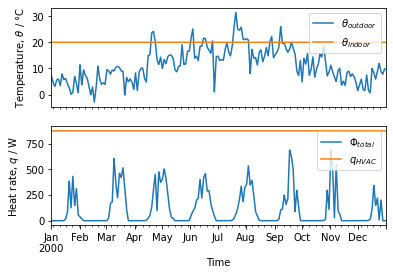

In [51]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 4. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

The indoor temperature is constant close to 20 °. In reality, this temperature is not constant but the variations are very small (of the order of a thousandth of a degree) and to this is added the fact that the evolution is studied over a long period (1 year). 

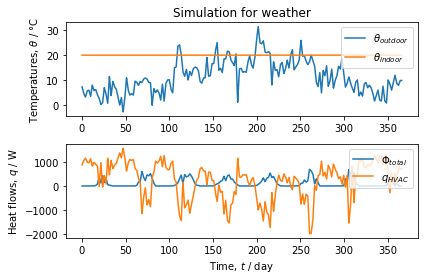

In [52]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 5. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

The indoor temperature is constant at around 20°. In reality, this temperature is not constant, but the variations are very small (of the order of a thousandth of a degree). We also note that ventilation is in tune with changes in outdoor temperature. Indeed, when the outdoor temperature drops, the system provides more power to heat the rooms. Conversely, when the temperature rises, power is reduced by ventilating to maintain the temperature at 20°C. 

## Discussion

Interchnage the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$).